In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4412 - acc: 0.3589
Epoch 00001: val_loss improved from inf to 1.73466, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_3_conv_checkpoint/001-1.7347.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.4410 - acc: 0.3589 - val_loss: 1.7347 - val_acc: 0.4379
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5130 - acc: 0.5568
Epoch 00002: val_loss improved from 1.73466 to 1.54924, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_3_conv_checkpoint/002-1.5492.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.5129 - acc: 0.5569 - val_loss: 1.5492 - val_acc: 0.5630
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2082 - acc: 0.6430
Epoch 00003: val_loss improved from 1.54924 to 

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1386 - acc: 0.9589
Epoch 00029: val_loss did not improve from 1.30276
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1386 - acc: 0.9589 - val_loss: 2.0559 - val_acc: 0.6597
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9548
Epoch 00030: val_loss did not improve from 1.30276
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1425 - acc: 0.9548 - val_loss: 1.9260 - val_acc: 0.6734
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9625
Epoch 00031: val_loss did not improve from 1.30276
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1254 - acc: 0.9625 - val_loss: 2.1904 - val_acc: 0.6406
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9608
Epoch 00032: val_loss did not improve from 1.30276
36805/36805 [===========

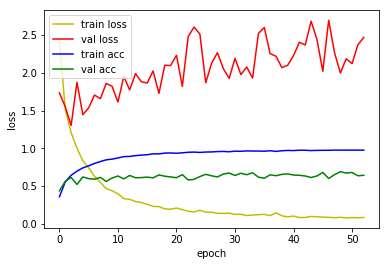

4815/4815 [==============================] - 3s 603us/sample - loss: 1.4145 - acc: 0.5699
Loss: 1.414538485634983 Accuracy: 0.5698858

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2267 - acc: 0.3609
Epoch 00001: val_loss improved from inf to 1.56417, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_4_conv_checkpoint/001-1.5642.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 2.2266 - acc: 0.3609 - val_loss: 1.5642 - val_acc: 0.5013
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4004 - acc: 0.5736
Epoch 00002: val_loss improved from 1.56417 to 1.09965, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_4_conv_checkpoint/002-1.0997.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.4004 - acc: 0.5736 - val_loss: 1.0997 - val_acc: 0.6681
Epoch 3/500
36800/36805 [============================>.]

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1856 - acc: 0.9394
Epoch 00028: val_loss did not improve from 0.89147
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1856 - acc: 0.9394 - val_loss: 1.0321 - val_acc: 0.7580
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1727 - acc: 0.9446
Epoch 00029: val_loss did not improve from 0.89147
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1727 - acc: 0.9446 - val_loss: 1.0683 - val_acc: 0.7533
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1779 - acc: 0.9417
Epoch 00030: val_loss did not improve from 0.89147
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1779 - acc: 0.9417 - val_loss: 1.0342 - val_acc: 0.7652
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1598 - acc: 0.9484
Epoch 00031: val_loss did not improve from 0.89147
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9749
Epoch 00058: val_loss did not improve from 0.89147
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0844 - acc: 0.9749 - val_loss: 1.0844 - val_acc: 0.7850
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0825 - acc: 0.9740
Epoch 00059: val_loss did not improve from 0.89147
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0826 - acc: 0.9740 - val_loss: 1.0668 - val_acc: 0.7824
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9739
Epoch 00060: val_loss did not improve from 0.89147
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0843 - acc: 0.9739 - val_loss: 1.0945 - val_acc: 0.7838
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9764
Epoch 00061: val_loss did not improve from 0.89147
36805/36805 [===========

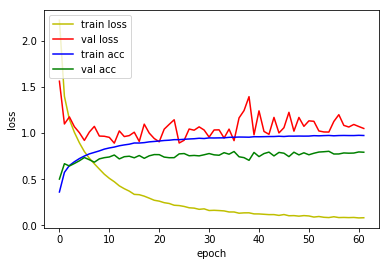

4815/4815 [==============================] - 3s 618us/sample - loss: 0.9842 - acc: 0.7161
Loss: 0.9842279992742331 Accuracy: 0.7160955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1379 - acc: 0.3668
Epoch 00001: val_loss improved from inf to 1.46362, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_5_conv_checkpoint/001-1.4636.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 2.1379 - acc: 0.3668 - val_loss: 1.4636 - val_acc: 0.5234
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3280 - acc: 0.5888
Epoch 00002: val_loss improved from 1.46362 to 1.01669, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_5_conv_checkpoint/002-1.0167.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.3282 - acc: 0.5887 - val_loss: 1.0167 - val_acc: 0.7016
Epoch 3/500
36800/36805 [============================>.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.9207
Epoch 00027: val_loss did not improve from 0.49183
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2505 - acc: 0.9207 - val_loss: 0.5449 - val_acc: 0.8588
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2359 - acc: 0.9252
Epoch 00028: val_loss did not improve from 0.49183
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.2359 - acc: 0.9251 - val_loss: 0.6989 - val_acc: 0.8218
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2327 - acc: 0.9283
Epoch 00029: val_loss improved from 0.49183 to 0.47455, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_5_conv_checkpoint/029-0.4746.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.2327 - acc: 0.9283 - val_loss: 0.4746 - val_acc: 0.8742
Epoch 30/500
36800/36805 [============================>.] - ETA: 

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9655
Epoch 00056: val_loss did not improve from 0.44772
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1075 - acc: 0.9655 - val_loss: 0.4911 - val_acc: 0.8845
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1123 - acc: 0.9634
Epoch 00057: val_loss did not improve from 0.44772
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1124 - acc: 0.9634 - val_loss: 0.6285 - val_acc: 0.8546
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9658
Epoch 00058: val_loss did not improve from 0.44772
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1037 - acc: 0.9657 - val_loss: 0.6211 - val_acc: 0.8481
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1094 - acc: 0.9635
Epoch 00059: val_loss did not improve from 0.44772
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9787
Epoch 00086: val_loss did not improve from 0.44772
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0649 - acc: 0.9786 - val_loss: 0.5379 - val_acc: 0.8859
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9768
Epoch 00087: val_loss did not improve from 0.44772
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0729 - acc: 0.9767 - val_loss: 0.6664 - val_acc: 0.8607
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9783
Epoch 00088: val_loss did not improve from 0.44772
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0693 - acc: 0.9783 - val_loss: 0.5573 - val_acc: 0.8751
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0661 - acc: 0.9798
Epoch 00089: val_loss did not improve from 0.44772
36805/36805 [===========

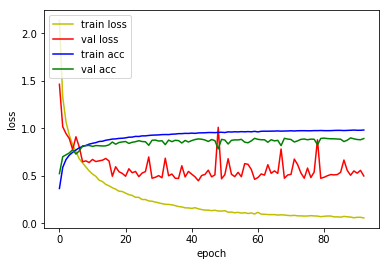

4815/4815 [==============================] - 3s 669us/sample - loss: 0.5304 - acc: 0.8577
Loss: 0.5303774013202386 Accuracy: 0.85773623

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1006 - acc: 0.3654
Epoch 00001: val_loss improved from inf to 1.67003, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_6_conv_checkpoint/001-1.6700.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.1007 - acc: 0.3654 - val_loss: 1.6700 - val_acc: 0.4510
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2343 - acc: 0.6127
Epoch 00002: val_loss improved from 1.67003 to 0.85433, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_6_conv_checkpoint/002-0.8543.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.2344 - acc: 0.6126 - val_loss: 0.8543 - val_acc: 0.7358
Epoch 3/500
36800/36805 [============================>

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1613 - acc: 0.9493
Epoch 00025: val_loss did not improve from 0.27939
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1614 - acc: 0.9492 - val_loss: 0.3734 - val_acc: 0.9015
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1547 - acc: 0.9502
Epoch 00026: val_loss did not improve from 0.27939
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1547 - acc: 0.9502 - val_loss: 0.2818 - val_acc: 0.9308
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9492
Epoch 00027: val_loss did not improve from 0.27939
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1534 - acc: 0.9491 - val_loss: 0.2980 - val_acc: 0.9224
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9530
Epoch 00028: val_loss did not improve from 0.27939
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9790
Epoch 00054: val_loss did not improve from 0.26611
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0651 - acc: 0.9790 - val_loss: 0.2844 - val_acc: 0.9371
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9795
Epoch 00055: val_loss did not improve from 0.26611
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0651 - acc: 0.9795 - val_loss: 0.2961 - val_acc: 0.9366
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.9772
Epoch 00056: val_loss did not improve from 0.26611
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0682 - acc: 0.9772 - val_loss: 0.2901 - val_acc: 0.9352
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9803
Epoch 00057: val_loss did not improve from 0.26611
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9860
Epoch 00083: val_loss did not improve from 0.26411
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0439 - acc: 0.9860 - val_loss: 0.2958 - val_acc: 0.9397
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9896
Epoch 00084: val_loss did not improve from 0.26411
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0345 - acc: 0.9896 - val_loss: 0.2910 - val_acc: 0.9408
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9882
Epoch 00085: val_loss did not improve from 0.26411
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0349 - acc: 0.9882 - val_loss: 0.3413 - val_acc: 0.9327
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9873
Epoch 00086: val_loss did not improve from 0.26411
36805/36805 [========================

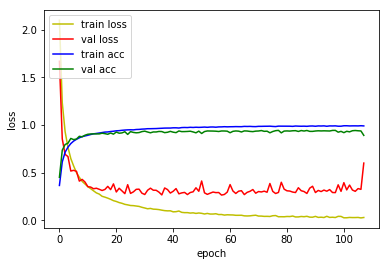

4815/4815 [==============================] - 3s 697us/sample - loss: 0.2986 - acc: 0.9213
Loss: 0.29863198925030193 Accuracy: 0.92128766

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1552 - acc: 0.3472
Epoch 00001: val_loss improved from inf to 1.36953, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_7_conv_checkpoint/001-1.3695.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 2.1551 - acc: 0.3473 - val_loss: 1.3695 - val_acc: 0.5632
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1605 - acc: 0.6308
Epoch 00002: val_loss improved from 1.36953 to 0.82601, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_7_conv_checkpoint/002-0.8260.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.1606 - acc: 0.6308 - val_loss: 0.8260 - val_acc: 0.7419
Epoch 3/500
36800/36805 [============================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1029 - acc: 0.9664
Epoch 00025: val_loss did not improve from 0.17000
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1029 - acc: 0.9664 - val_loss: 0.1773 - val_acc: 0.9499
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0978 - acc: 0.9673
Epoch 00026: val_loss did not improve from 0.17000
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0978 - acc: 0.9673 - val_loss: 0.1888 - val_acc: 0.9453
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9709
Epoch 00027: val_loss did not improve from 0.17000
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0910 - acc: 0.9709 - val_loss: 0.1967 - val_acc: 0.9502
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9694
Epoch 00028: val_loss improved from 0.17000 to 0.16328, saving model to mod

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9870
Epoch 00054: val_loss did not improve from 0.15350
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0391 - acc: 0.9870 - val_loss: 0.2039 - val_acc: 0.9504
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9892
Epoch 00055: val_loss did not improve from 0.15350
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0363 - acc: 0.9892 - val_loss: 0.1792 - val_acc: 0.9555
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9905
Epoch 00056: val_loss did not improve from 0.15350
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0304 - acc: 0.9905 - val_loss: 0.1917 - val_acc: 0.9560
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9902
Epoch 00057: val_loss did not improve from 0.15350
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9942
Epoch 00084: val_loss did not improve from 0.15350
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0182 - acc: 0.9942 - val_loss: 0.2310 - val_acc: 0.9532
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9942
Epoch 00085: val_loss did not improve from 0.15350
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0187 - acc: 0.9942 - val_loss: 0.2389 - val_acc: 0.9441
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9936
Epoch 00086: val_loss did not improve from 0.15350
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0203 - acc: 0.9936 - val_loss: 0.2392 - val_acc: 0.9509

1D_CNN_custom_multi_2_concat_DO_BN_7_conv Model


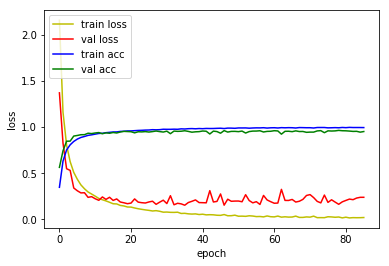

4815/4815 [==============================] - 3s 706us/sample - loss: 0.1916 - acc: 0.9445
Loss: 0.1915753168960103 Accuracy: 0.9445483

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0626 - acc: 0.3874
Epoch 00001: val_loss improved from inf to 1.43547, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_8_conv_checkpoint/001-1.4355.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 2.0627 - acc: 0.3874 - val_loss: 1.4355 - val_acc: 0.5304
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0009 - acc: 0.6858
Epoch 00002: val_loss improved from 1.43547 to 0.53513, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_DO_BN_8_conv_checkpoint/002-0.5351.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.0009 - acc: 0.6858 - val_loss: 0.5351 - val_acc: 0.8453
Epoch 3/500
36800/36805 [============================>.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9783
Epoch 00026: val_loss did not improve from 0.12980
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0698 - acc: 0.9782 - val_loss: 0.1987 - val_acc: 0.9455
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0689 - acc: 0.9779
Epoch 00027: val_loss did not improve from 0.12980
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0690 - acc: 0.9778 - val_loss: 0.1346 - val_acc: 0.9599
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9779
Epoch 00028: val_loss did not improve from 0.12980
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0696 - acc: 0.9779 - val_loss: 0.1389 - val_acc: 0.9611
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0577 - acc: 0.9825
Epoch 00029: val_loss did not improve from 0.12980
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9930
Epoch 00056: val_loss did not improve from 0.12980
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0229 - acc: 0.9930 - val_loss: 0.1665 - val_acc: 0.9620
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9940
Epoch 00057: val_loss did not improve from 0.12980
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0216 - acc: 0.9940 - val_loss: 0.1381 - val_acc: 0.9660
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9941
Epoch 00058: val_loss did not improve from 0.12980
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0203 - acc: 0.9941 - val_loss: 0.1829 - val_acc: 0.9574
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9901
Epoch 00059: val_loss did not improve from 0.12980
36805/36805 [===========

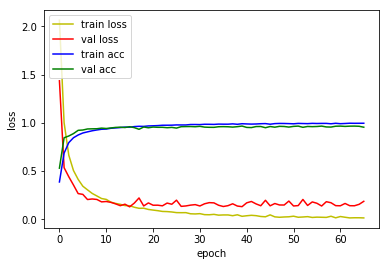

4815/4815 [==============================] - 4s 744us/sample - loss: 0.1814 - acc: 0.9441
Loss: 0.1813951828181434 Accuracy: 0.9441329



In [10]:
base = '1D_CNN_custom_multi_2_concat_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 707us/sample - loss: 0.9842 - acc: 0.7161
Loss: 0.9842279992742331 Accuracy: 0.7160955

1D_CNN_custom_multi_2_concat_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 4s 767us/sample - loss: 0.2986 - acc: 0.9213
Loss: 0.29863198925030193 Accuracy: 0.92128766

1D_CNN_custom_multi_2_concat_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activat

4815/4815 [==============================] - 4s 804us/sample - loss: 0.1814 - acc: 0.9441
Loss: 0.1813951828181434 Accuracy: 0.9441329


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
____________________________________________________________

4815/4815 [==============================] - 4s 801us/sample - loss: 1.1726 - acc: 0.7572
Loss: 1.1725702812738508 Accuracy: 0.75721705

1D_CNN_custom_multi_2_concat_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activati

4815/4815 [==============================] - 4s 851us/sample - loss: 0.7012 - acc: 0.8712
Loss: 0.7012080360486376 Accuracy: 0.8712357

1D_CNN_custom_multi_2_concat_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 4s 891us/sample - loss: 0.2629 - acc: 0.9421
Loss: 0.2629415217754146 Accuracy: 0.94205606
